In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import warnings

warnings.filterwarnings('ignore') # 경고 무시

%matplotlib inline

In [2]:
'''
데이터 불러오기
'''
original_data_df = pd.read_csv('./data/Sunspots.csv', index_col=0)

In [3]:
original_data_df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [4]:
original_data_df.shape

(3252, 2)

In [5]:
'''
데이터프레임 컬럼 이름 변경
'''
original_data_df.columns = ['Month', 'Sunspots']

In [6]:
original_data_df.head()

,Month,Sunspots
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [7]:
'''
날짜 datetime 타입으로 변환
'''
original_data_date_list = original_data_df['Month'].tolist()
original_data_date_list = pd.to_datetime(original_data_date_list)
original_data_df['Month'] = original_data_date_list

In [8]:
original_data_df.head()

,Month,Sunspots
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [9]:
type(original_data_df['Month'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [10]:
'''
Month 컬럼 인덱스 부여
'''
original_data_df = original_data_df.set_index('Month').astype(int) # Month 컬럼에 인덱스 부여

In [11]:
print(original_data_df.head())

            Sunspots
Month               
1749-01-31        96
1749-02-28       104
1749-03-31       116
1749-04-30        92
1749-05-31       141


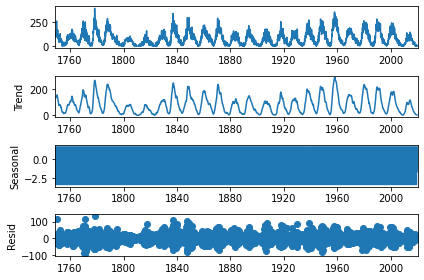

In [12]:
'''
statsmodels.tsa.seasonal - seasonal_decompose 분석 (trend, seasonal, resid)
'''

result = seasonal_decompose(original_data_df, model = 'additive')
re_plot = result.plot()
plt.show()

In [13]:
'''
trend, seasonal, resid 데이터 저장
'''
result_df = pd.DataFrame(
    {
        'Observed': result.observed, 
        'Trend': result.trend, 
        'Seasonal': result.seasonal, 
        'Resid': result.resid
    }
)
result_df.reset_index(level = 0, inplace = True)
result_df.dropna(axis = 0, inplace = True)
result_df.reset_index(drop = True, inplace = True)

In [14]:
result_df.head()

,Month,Observed,Trend,Seasonal,Resid
0,1749-07-31,158.0,135.500000,0.559697,21.940303
1,1749-08-31,110.0,137.500000,1.663555,-29.163555
2,1749-09-30,126.0,139.750000,1.185005,-14.935005
3,1749-10-31,125.0,143.375000,1.043956,-19.418956
4,1749-11-30,264.0,146.041667,-0.693236,118.651569


In [15]:
'''
특성간 상관관계

각 특성들은 종속적인 관계가 아닌 독립적인 요소
'''
result_df.corr()

,Observed,Trend,Seasonal,Resid
Observed,1.000000,0.947265,2.066681e-02,3.678280e-01
Trend,0.947265,1.000000,5.139659e-04,5.112784e-02
Seasonal,0.020667,0.000514,1.000000e+00,6.457226e-17
Resid,0.367828,0.051128,6.457226e-17,1.000000e+00


In [16]:
result_df.drop(['Observed'], axis = 1).corr()

,Trend,Seasonal,Resid
Trend,1.000000,5.139659e-04,5.112784e-02
Seasonal,0.000514,1.000000e+00,6.457226e-17
Resid,0.051128,6.457226e-17,1.000000e+00


<AxesSubplot:>

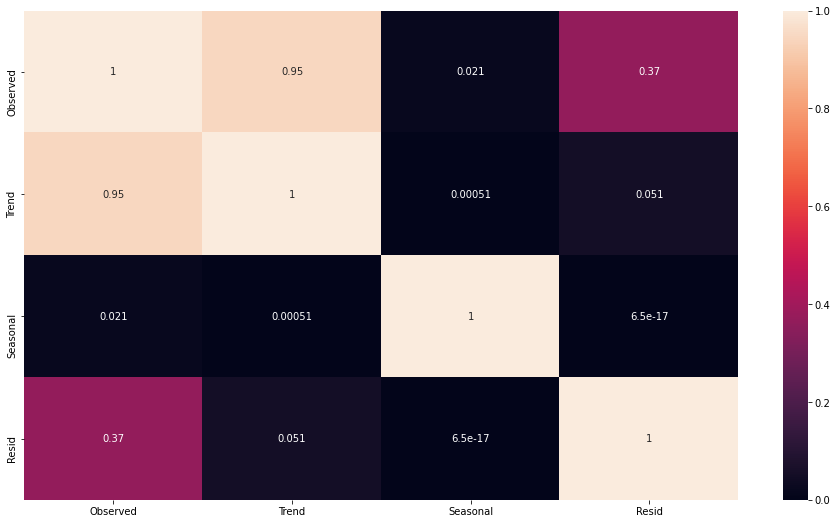

In [17]:
'''
seasonal 데이터는 매우 작은 영향을 미침
관측된 데이터에 대해서 Trend, Residual, Seasonal 순으로 영향을 미치는 정도가 다름
'''

plt.figure(figsize = (16, 9))
sns.heatmap(result_df.drop(['Month'], axis = 1).corr(), annot = True)

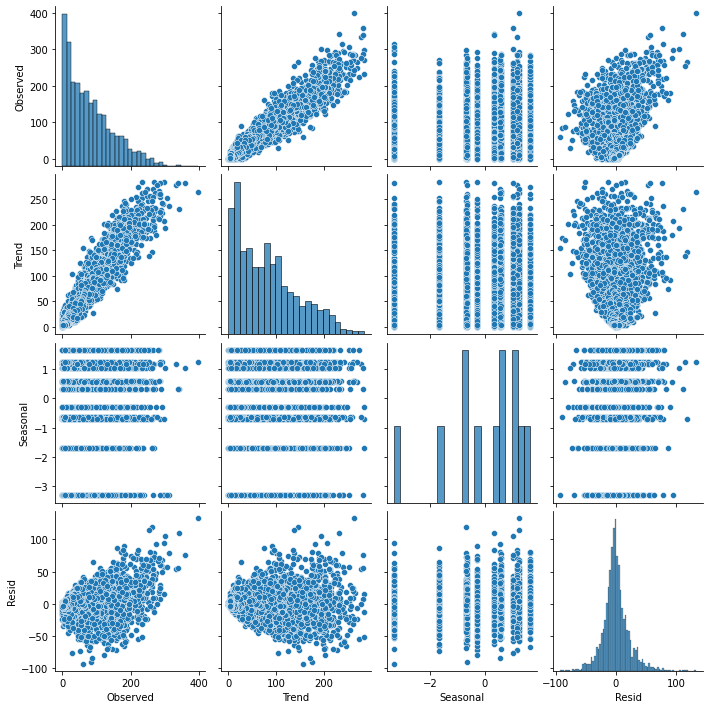

In [18]:
sns.pairplot(result_df)

In [19]:
'''
데이터간 독립성 확인
'''
result_df.head()

,Month,Observed,Trend,Seasonal,Resid
0,1749-07-31,158.0,135.500000,0.559697,21.940303
1,1749-08-31,110.0,137.500000,1.663555,-29.163555
2,1749-09-30,126.0,139.750000,1.185005,-14.935005
3,1749-10-31,125.0,143.375000,1.043956,-19.418956
4,1749-11-30,264.0,146.041667,-0.693236,118.651569


In [20]:
print(result_df['Trend'][0] + result_df['Seasonal'][0] + result_df['Resid'][0])
print(result_df['Trend'][1] + result_df['Seasonal'][1] + result_df['Resid'][1])
print(result_df['Trend'][2] + result_df['Seasonal'][2] + result_df['Resid'][2])

158.0
110.00000000000001
125.99999999999999


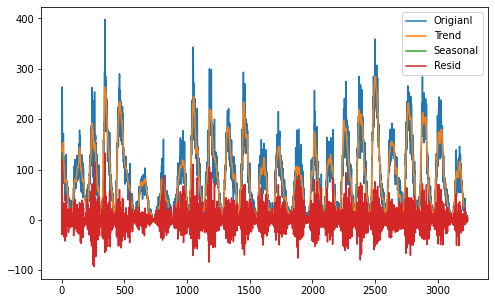

In [21]:
'''
decomposed data 시각화
'''
plt.figure(figsize = (8, 5))
plt.plot(result_df['Observed'], label = 'Origianl')
plt.plot(result_df['Trend'], label = 'Trend')
plt.plot(result_df['Seasonal'], label = 'Seasonal')
plt.plot(result_df['Resid'], label = 'Resid')
plt.legend(loc = 'upper right')
plt.show()

In [22]:
'''
날짜 하이픈 제거 및 데이터타입 변환
'''
result_df['Month'] = result_df['Month'].astype(str)
result_df['Month'] = result_df['Month'].str.replace(pat=r'[^\w\s]', repl=r'', regex=True) # 하이픈제거
result_df = result_df.astype('int')

In [23]:
result_df.head()

,Month,Observed,Trend,Seasonal,Resid
0,17490731,158,135,0,21
1,17490831,110,137,1,-29
2,17490930,126,139,1,-14
3,17491031,125,143,1,-19
4,17491130,264,146,0,118


In [24]:
'''
스케일링
'''
#scaler = MaxAbsScaler()
scaler = MinMaxScaler()
scaled_result_np = scaler.fit_transform(result_df)
#scaled_result_np = scaler.fit_transform(result_df)

In [25]:
'''
데이터프레임 재생성
'''
scaled_result_df = pd.DataFrame(scaled_result_np)
scaled_result_df.columns = ['Month', 'Observed', 'Trend', 'Seasonal', 'Resid']

In [26]:
scaled_result_df.head()

,Month,Observed,Trend,Seasonal,Resid
0,0.000000,0.396985,0.475352,0.75,0.504464
1,0.000037,0.276382,0.482394,1.00,0.281250
2,0.000074,0.316583,0.489437,1.00,0.348214
3,0.000111,0.314070,0.503521,1.00,0.325893
4,0.000148,0.663317,0.514085,0.75,0.937500


In [27]:
'''
train, test data 분리
'''
train_size = int(len(scaled_result_df) * 0.7)
train_data_df = scaled_result_df[0:train_size].reset_index(drop = True)
validation_data_df = scaled_result_df[:int(len(scaled_result_df) * 0.15):].reset_index(drop = True)
test_data_df = scaled_result_df[-int(len(scaled_result_df) * 0.15):].reset_index(drop = True)

In [28]:
print("train size:", train_size)
print("result df shape:", scaled_result_df.shape)
print("train df shape:", train_data_df.shape)
print("validation df shape:", validation_data_df.shape)
print("test df shape:", test_data_df.shape)

train size: 2268
result df shape: (3240, 5)
train df shape: (2268, 5)
validation df shape: (486, 5)
test df shape: (486, 5)


In [29]:
'''
input, label data 분리
'''
x_train_data_df = train_data_df[['Month', 'Trend', 'Seasonal', 'Resid']]
y_train_data_df = train_data_df[['Trend', 'Seasonal', 'Resid']]

x_validation_data_df = validation_data_df[['Month', 'Trend', 'Seasonal', 'Resid']]
y_validation_data_df = validation_data_df[['Trend', 'Seasonal', 'Resid']]

x_test_data_df = test_data_df[['Month', 'Trend', 'Seasonal', 'Resid']]
y_test_data_df = test_data_df[['Trend', 'Seasonal', 'Resid']]

In [30]:
print("x train shape:", x_train_data_df.shape)
print("y train shape:", y_train_data_df.shape)
print("x validation shape:", x_validation_data_df.shape)
print("y validation shape:", y_validation_data_df.shape)
print("x test shape", x_test_data_df.shape)
print("y test shape", y_test_data_df.shape)

x train shape: (2268, 4)
y train shape: (2268, 3)
x validation shape: (486, 4)
y validation shape: (486, 3)
x test shape (486, 4)
y test shape (486, 3)


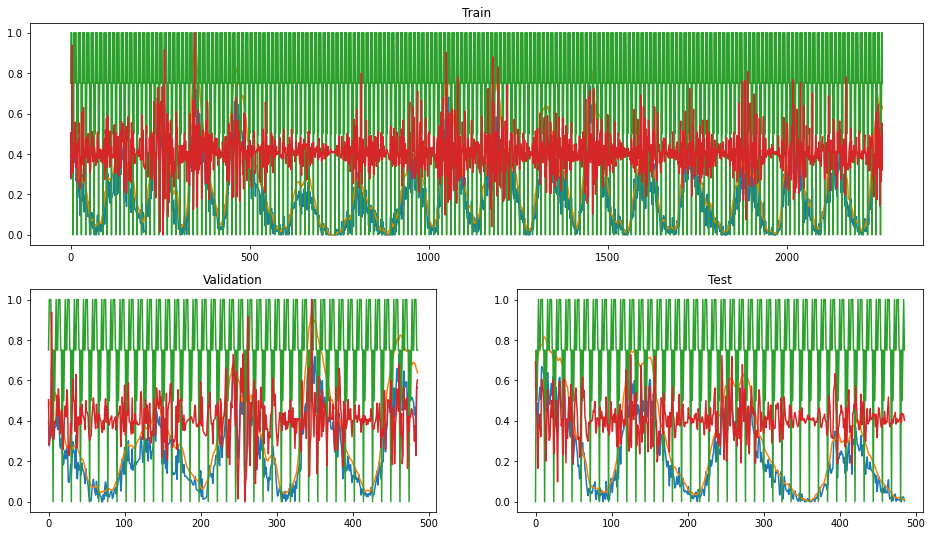

In [31]:
'''
scaled data 시각화
'''
plt.figure(figsize = (16, 9))

plt.subplot(211)
plt.plot(train_data_df.drop(['Month'], axis = 1))
plt.title('Train')

plt.subplot(223)
plt.plot(validation_data_df.drop(['Month'], axis = 1))
plt.title('Validation')

plt.subplot(224)
plt.plot(test_data_df.drop(['Month'], axis = 1))
plt.title('Test')

plt.show()

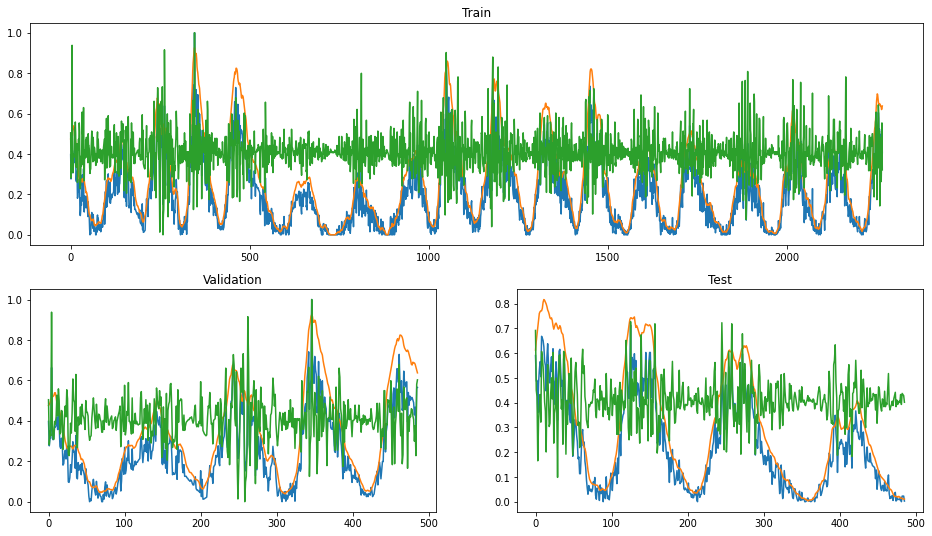

In [32]:
'''
가시성을 위해 seasonal data를 제거하고 시각화
'''
plt.figure(figsize = (16, 9))

plt.subplot(211)
plt.plot(train_data_df.drop(['Month', 'Seasonal'], axis = 1))
plt.title('Train')

plt.subplot(223)
plt.plot(validation_data_df.drop(['Month', 'Seasonal'], axis = 1))
plt.title('Validation')

plt.subplot(224)
plt.plot(test_data_df.drop(['Month', 'Seasonal'], axis = 1))
plt.title('Test')

plt.show()

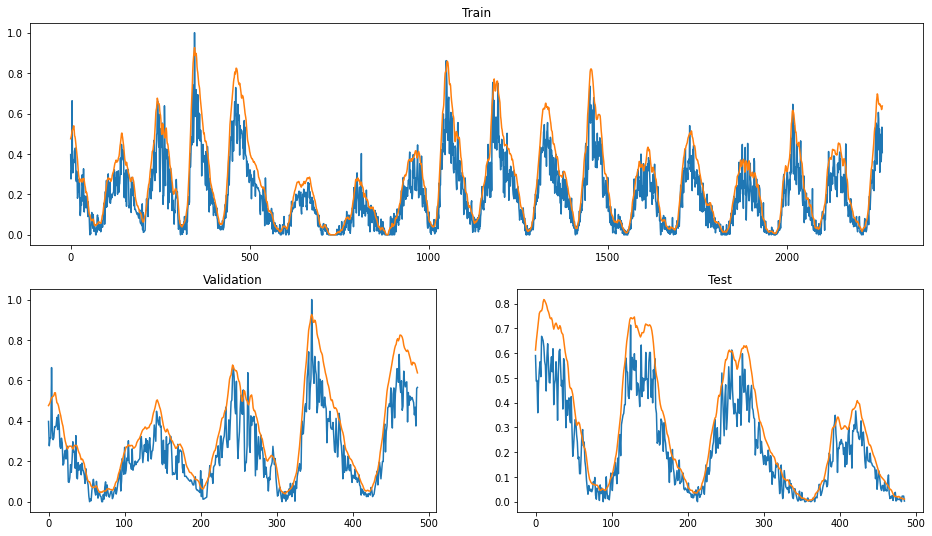

In [33]:
'''
가시성을 위해 seasonal data를 제거하고 시각화

* 학습에 사용할 데이터
'''
plt.figure(figsize = (16, 9))

plt.subplot(211)
plt.plot(train_data_df.drop(['Month', 'Seasonal', 'Resid'], axis = 1))
plt.title('Train')

plt.subplot(223)
plt.plot(validation_data_df.drop(['Month', 'Seasonal', 'Resid'], axis = 1))
plt.title('Validation')

plt.subplot(224)
plt.plot(test_data_df.drop(['Month', 'Seasonal', 'Resid'], axis = 1))
plt.title('Test')

plt.show()

In [34]:
'''
seasonal, trend 데이터와 같은 이상치 데이터는 학습에 지대한 영향을 미치기 때문에 학습에서 제외하고
학습이 끝난 결과 데이터에 연산할 목적으로 분리시킴
'''
x_train_input_df = train_data_df[['Month', 'Trend']]
x_train_outlier_df = train_data_df[['Seasonal', 'Resid']]
y_train_target_df = train_data_df[['Trend']]

x_validation_input_df = validation_data_df[['Month', 'Trend']]
x_validation_outlier_df = validation_data_df[['Seasonal', 'Resid']]
y_validation_target_df = validation_data_df[['Trend']]

x_test_input_df = test_data_df[['Month', 'Trend']]
x_test_outlier_df = test_data_df[['Seasonal', 'Resid']]
y_test_target_df = test_data_df[['Trend']]

In [35]:
print("x train input shape:", x_train_input_df.shape)
print("x train outlier shape:", x_train_outlier_df.shape)
print("y train target shape:", y_train_target_df.shape)

print("x validation input shape:", x_validation_input_df.shape)
print("x validation outlier shape:", x_validation_outlier_df.shape)
print("y validation target shape:", y_validation_target_df.shape)

print("x test input shape:", x_test_input_df.shape)
print("x test outlier shape:", x_test_outlier_df.shape)
print("y test target shape:", y_test_target_df.shape)

x train input shape: (2268, 2)
x train outlier shape: (2268, 2)
y train target shape: (2268, 1)
x validation input shape: (486, 2)
x validation outlier shape: (486, 2)
y validation target shape: (486, 1)
x test input shape: (486, 2)
x test outlier shape: (486, 2)
y test target shape: (486, 1)


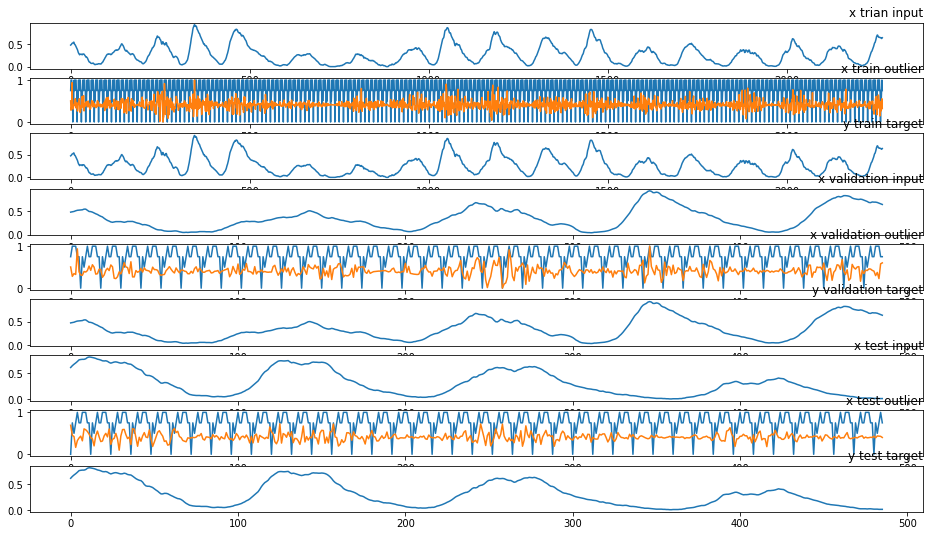

In [36]:
'''
데이터 시각화
'''
plt.figure(figsize = (16, 9))

plt.subplot(911)
plt.plot(x_train_input_df.drop(['Month'], axis = 1))
plt.title('x trian input', loc = 'right')

plt.subplot(912)
plt.plot(x_train_outlier_df)
plt.title('x train outlier', loc = 'right')

plt.subplot(913)
plt.plot(y_train_target_df)
plt.title('y train target', loc = 'right')

plt.subplot(914)
plt.plot(x_validation_input_df.drop(['Month'], axis = 1))
plt.title('x validation input', loc = 'right')

plt.subplot(915)
plt.plot(x_validation_outlier_df)
plt.title('x validation outlier', loc = 'right')

plt.subplot(916)
plt.plot(y_validation_target_df)
plt.title('y validation target', loc = 'right')

plt.subplot(917)
plt.plot(x_test_input_df.drop(['Month'], axis = 1))
plt.title('x test input', loc = 'right')

plt.subplot(918)
plt.plot(x_test_outlier_df)
plt.title('x test outlier', loc = 'right')

plt.subplot(919)
plt.plot(y_test_target_df)
plt.title('y test target', loc = 'right')

plt.show()

In [37]:
'''
GPU 사용
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
print(device)

cpu


In [39]:
'''
랜덤시드 고정
'''
torch.manual_seed(777)

In [40]:
'''
하이퍼파라미터

입력 형태: (Batch Size, Sequence Length, Input Dimension)

태양 주기(태양 자기 활동 주기)는 태양 활동(태양 복사의 강도와 태양 물질의 분출에서의 변화를 포함)과 
태양의 겉표면(흑점의 개수, 플레어, 다른 가시적인 징후들)에서 보여지는 주기적인 변화를 말함
'''
batch_size = 11 # Sequence  태양 주기
sequence_length = 1 # 한 개의 batch 당 몇 개의 sequence가 들어있는 개수
input_size = 2 # 1개의 sequence의 내부에 4개의 데이터
hidden_size = 32
num_layers = 3
output_size = 1 # Trend, Seasonal, Residual
learning_rate = 1e-4
nb_epochs = 400

In [41]:
'''
데이터셋함수
'''
def MakeDataSet(x_data_df, y_data_df):
    x_ts = torch.FloatTensor(np.array(x_data_df))
    y_ts = torch.FloatTensor(np.array(y_data_df))
    dataset_ts = TensorDataset(x_ts, y_ts)

    return dataset_ts

'''
데이터로더
'''
def MakeDataLoader(dataset, batch_size):
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

    return dataloader

In [42]:
'''
데이터셋
'''
train_dataset_ts = MakeDataSet(x_train_input_df, y_train_target_df)
validation_dataset_ts = MakeDataSet(x_validation_input_df, y_validation_target_df)
test_dataset_ts = MakeDataSet(x_test_input_df, y_test_target_df)

'''
데이터로더
'''
train_dataloader = MakeDataLoader(train_dataset_ts, batch_size)
validation_dataloader = MakeDataLoader(validation_dataset_ts, batch_size)
test_dataloader = MakeDataLoader(test_dataset_ts, batch_size)

In [43]:
'''
사용할 데이터 확인
'''
for i, samples in enumerate(test_dataloader):
    x, y = samples
    print("Batch:", i + 1)
    print("Input:",x.shape)
    print("Target:",y.shape)
    if i == 4:
        break

Batch: 1
Input: torch.Size([11, 2])
Target: torch.Size([11, 1])
Batch: 2
Input: torch.Size([11, 2])
Target: torch.Size([11, 1])
Batch: 3
Input: torch.Size([11, 2])
Target: torch.Size([11, 1])
Batch: 4
Input: torch.Size([11, 2])
Target: torch.Size([11, 1])
Batch: 5
Input: torch.Size([11, 2])
Target: torch.Size([11, 1])


In [44]:

'''
model 설계
'''
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = 0.3,
            batch_first = True
        )
        self.fc = nn.Linear(
            hidden_size,
            output_size,
            bias = True
        )

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

In [45]:
'''
model, cost, optimizer
'''
model = Net(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [46]:
'''
모델 테스트
'''
x, y = list(train_dataloader)[0]
x = x.view(-1, sequence_length, input_size).to(device) # RNN input: batch size, sequence length, input size
y = y.to(device)
hypothesis = model(x)
loss = criterion(hypothesis, y)

In [47]:
print("X shape:", x, x.shape)
print("Y shape:", y.shape)
print("Hypothesis:", hypothesis)
print("Optimizer:", optimizer)
print("Loss:", loss)

X shape: tensor([[[0.3075, 0.1373]],

        [[0.3666, 0.7289]],

        [[0.0962, 0.0458]],

        [[0.0150, 0.0986]],

        [[0.4630, 0.2465]],

        [[0.5447, 0.2042]],

        [[0.0335, 0.2676]],

        [[0.6702, 0.3099]],

        [[0.0259, 0.0563]],

        [[0.2558, 0.1373]],

        [[0.6149, 0.3134]]]) torch.Size([11, 1, 2])
Y shape: torch.Size([11, 1])
Hypothesis: tensor([[-0.1060],
        [-0.1090],
        [-0.1088],
        [-0.1064],
        [-0.1046],
        [-0.1063],
        [-0.1102],
        [-0.1107],
        [-0.1060],
        [-0.1100],
        [-0.1076]], grad_fn=<AddmmBackward>)
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
Loss: tensor(0.1483, grad_fn=<MseLossBackward>)


In [48]:
for i, samples in enumerate(train_dataloader):
    x, y = samples
    print(i + 1)
    x = x.view(-1, sequence_length, input_size).to(device)
    y = y.to(device)
    print(x)
    if i == 4:
        break

1
tensor([[[0.3628, 0.3838]],

        [[0.5520, 0.1197]],

        [[0.0220, 0.0528]],

        [[0.2335, 0.0352]],

        [[0.3257, 0.8345]],

        [[0.5554, 0.1092]],

        [[0.0740, 0.6056]],

        [[0.6593, 0.4014]],

        [[0.2593, 0.1303]],

        [[0.6480, 0.0528]],

        [[0.6852, 0.0493]]])
2
tensor([[[0.4112, 0.6232]],

        [[0.1850, 0.0423]],

        [[0.6110, 0.0352]],

        [[0.1409, 0.7958]],

        [[0.3852, 0.2641]],

        [[0.5075, 0.1338]],

        [[0.3924, 0.0845]],

        [[0.3149, 0.0775]],

        [[0.5221, 0.0246]],

        [[0.1740, 0.1056]],

        [[0.3555, 0.1937]]])
3
tensor([[[0.5817, 0.3486]],

        [[0.6113, 0.1408]],

        [[0.5481, 0.1620]],

        [[0.6557, 0.3908]],

        [[0.6261, 0.4437]],

        [[0.3776, 0.4331]],

        [[0.3146, 0.0423]],

        [[0.3259, 0.8486]],

        [[0.0409, 0.3873]],

        [[0.5481, 0.1549]],

        [[0.3591, 0.2852]]])
4
tensor([[[0.2221, 0.0246]],

      

In [49]:
'''
학습
'''
trn_loss_list = []
trn_acc_list = []
val_loss_list = []
val_acc_list = []
# Train
for epoch in range(nb_epochs):
    # Train Parameters
    trn_loss = 0.0
    trn_correct = 0
    for i, samples in enumerate(train_dataloader):
        # Train Data
        x_train, y_train = samples
        x_train = x_train.view(-1, sequence_length, input_size).to(device)
        y_train = y_train.to(device)
        
        # Train
        model.train()
        hypothesis = model(x_train)
        optimizer.zero_grad()
        train_loss = criterion(hypothesis, y_train)
        train_loss.backward()
        optimizer.step()
        
        # Train Loss
        trn_loss += train_loss.item() / len(train_dataloader)
        
        # Train Accuracy
        trn_batch_length = y_train.size(0)
        trn_correct = 0.0
        trn_correct += abs(100 * (1 - (abs(abs(hypothesis) - abs(y_train)) / abs(y_train)))).sum().item()
        trn_acc = trn_correct / trn_batch_length
    trn_acc_list.append(trn_acc)
    trn_loss_list.append(trn_loss)

    # Evaluation
    with torch.no_grad():
        # Validation Parameters
        val_loss = 0.0
        val_acc = 0.0
        for ii, validation_samples in enumerate(validation_dataloader):
            # Validation Data
            x_validation, y_validation = validation_samples
            x_validation = x_validation.view(-1, sequence_length, input_size).to(device)
            y_validation = y_validation.to(device)
            
            # Evaluation
            model.eval()
            prediction = model(x_validation)
            validation_loss = criterion(prediction, y_validation)
            
            # Validation Loss
            val_loss += validation_loss.item() / len(validation_dataloader)
            
            # Validation Accuracy
            val_batch_length = y_validation.size(0)
            val_correct = 0.0
            val_correct += abs(100 * (1 - (abs(abs(prediction) - abs(y_validation)) / abs(y_validation)))).sum().item()
            val_acc = val_correct  / val_batch_length
        val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    
    print("Epoch: {:3d} | Train Loss: {:.6f} | Val Loss: {:.6f} | Train Acc: {:.2f} | Val Acc: {:.2f}".format(epoch + 1, trn_loss, val_loss, trn_acc, val_acc))
    if epoch > nb_epochs / 3: 
        if trn_loss  < 0.00002 and val_loss < 0.00002:
            break
        else:
            continue

torch.save(model, './data/model.pt')

Epoch:   1 | Train Loss: 0.149078 | Val Loss: 0.172713 | Train Acc: inf | Val Acc: 1.92
Epoch:   2 | Train Loss: 0.082147 | Val Loss: 0.082015 | Train Acc: 48.64 | Val Acc: 41.13
Epoch:   3 | Train Loss: 0.042185 | Val Loss: 0.054806 | Train Acc: 68.91 | Val Acc: 50.17
Epoch:   4 | Train Loss: 0.038047 | Val Loss: 0.047992 | Train Acc: 155.63 | Val Acc: 56.73
Epoch:   5 | Train Loss: 0.035281 | Val Loss: 0.044123 | Train Acc: 51.64 | Val Acc: 63.73
Epoch:   6 | Train Loss: 0.032977 | Val Loss: 0.039933 | Train Acc: 462.89 | Val Acc: 91.50
Epoch:   7 | Train Loss: 0.030247 | Val Loss: 0.035756 | Train Acc: 288.06 | Val Acc: 79.03
Epoch:   8 | Train Loss: 0.026621 | Val Loss: 0.029624 | Train Acc: 81.43 | Val Acc: 71.41
Epoch:   9 | Train Loss: 0.020475 | Val Loss: 0.020004 | Train Acc: 233.12 | Val Acc: 100.18
Epoch:  10 | Train Loss: 0.015495 | Val Loss: 0.011679 | Train Acc: 367.60 | Val Acc: 83.12
Epoch:  11 | Train Loss: 0.010721 | Val Loss: 0.005399 | Train Acc: 81.59 | Val Acc: 88

Epoch:  91 | Train Loss: 0.001048 | Val Loss: 0.000235 | Train Acc: 95.35 | Val Acc: 99.75
Epoch:  92 | Train Loss: 0.001068 | Val Loss: 0.000166 | Train Acc: 76.24 | Val Acc: 99.51
Epoch:  93 | Train Loss: 0.001022 | Val Loss: 0.000149 | Train Acc: 63.36 | Val Acc: 98.57
Epoch:  94 | Train Loss: 0.000961 | Val Loss: 0.000202 | Train Acc: 89.90 | Val Acc: 96.11
Epoch:  95 | Train Loss: 0.001031 | Val Loss: 0.000197 | Train Acc: 88.23 | Val Acc: 99.15
Epoch:  96 | Train Loss: 0.001024 | Val Loss: 0.000154 | Train Acc: 94.93 | Val Acc: 95.92
Epoch:  97 | Train Loss: 0.001042 | Val Loss: 0.000200 | Train Acc: 80.71 | Val Acc: 98.27
Epoch:  98 | Train Loss: 0.001117 | Val Loss: 0.000176 | Train Acc: 90.65 | Val Acc: 98.00
Epoch:  99 | Train Loss: 0.001055 | Val Loss: 0.000185 | Train Acc: inf | Val Acc: 96.31
Epoch: 100 | Train Loss: 0.001040 | Val Loss: 0.000162 | Train Acc: 51.96 | Val Acc: 99.10
Epoch: 101 | Train Loss: 0.001025 | Val Loss: 0.000246 | Train Acc: 99.43 | Val Acc: 99.02
E

Epoch: 182 | Train Loss: 0.000940 | Val Loss: 0.000259 | Train Acc: 49.14 | Val Acc: 98.00
Epoch: 183 | Train Loss: 0.000967 | Val Loss: 0.000267 | Train Acc: 95.53 | Val Acc: 98.15
Epoch: 184 | Train Loss: 0.000919 | Val Loss: 0.000260 | Train Acc: 64.72 | Val Acc: 99.30
Epoch: 185 | Train Loss: 0.000971 | Val Loss: 0.000246 | Train Acc: 45.57 | Val Acc: 97.24
Epoch: 186 | Train Loss: 0.000907 | Val Loss: 0.000262 | Train Acc: 96.77 | Val Acc: 95.98
Epoch: 187 | Train Loss: 0.000974 | Val Loss: 0.000261 | Train Acc: 96.57 | Val Acc: 92.79
Epoch: 188 | Train Loss: 0.000946 | Val Loss: 0.000260 | Train Acc: 63.54 | Val Acc: 95.96
Epoch: 189 | Train Loss: 0.000963 | Val Loss: 0.000247 | Train Acc: 87.11 | Val Acc: 98.78
Epoch: 190 | Train Loss: 0.000954 | Val Loss: 0.000237 | Train Acc: 55.59 | Val Acc: 95.05
Epoch: 191 | Train Loss: 0.000887 | Val Loss: 0.000260 | Train Acc: inf | Val Acc: 97.83
Epoch: 192 | Train Loss: 0.000987 | Val Loss: 0.000234 | Train Acc: 97.84 | Val Acc: 98.24
E

Epoch: 273 | Train Loss: 0.000916 | Val Loss: 0.000238 | Train Acc: 87.67 | Val Acc: 94.36
Epoch: 274 | Train Loss: 0.000828 | Val Loss: 0.000221 | Train Acc: 91.73 | Val Acc: 96.83
Epoch: 275 | Train Loss: 0.000831 | Val Loss: 0.000226 | Train Acc: 94.07 | Val Acc: 97.38
Epoch: 276 | Train Loss: 0.000843 | Val Loss: 0.000220 | Train Acc: 95.58 | Val Acc: 97.02
Epoch: 277 | Train Loss: 0.000870 | Val Loss: 0.000244 | Train Acc: 96.66 | Val Acc: 97.05
Epoch: 278 | Train Loss: 0.000882 | Val Loss: 0.000231 | Train Acc: 80.16 | Val Acc: 97.28
Epoch: 279 | Train Loss: 0.000861 | Val Loss: 0.000222 | Train Acc: 89.96 | Val Acc: 95.80
Epoch: 280 | Train Loss: 0.000786 | Val Loss: 0.000223 | Train Acc: 98.21 | Val Acc: 98.17
Epoch: 281 | Train Loss: 0.000874 | Val Loss: 0.000224 | Train Acc: 93.45 | Val Acc: 98.40
Epoch: 282 | Train Loss: 0.000854 | Val Loss: 0.000240 | Train Acc: 96.47 | Val Acc: 97.25
Epoch: 283 | Train Loss: 0.000894 | Val Loss: 0.000235 | Train Acc: 97.96 | Val Acc: 95.39

Epoch: 364 | Train Loss: 0.000838 | Val Loss: 0.000180 | Train Acc: 91.69 | Val Acc: 94.05
Epoch: 365 | Train Loss: 0.000841 | Val Loss: 0.000170 | Train Acc: 90.43 | Val Acc: 96.96
Epoch: 366 | Train Loss: 0.000882 | Val Loss: 0.000206 | Train Acc: 92.59 | Val Acc: 95.68
Epoch: 367 | Train Loss: 0.000809 | Val Loss: 0.000225 | Train Acc: 96.11 | Val Acc: 97.44
Epoch: 368 | Train Loss: 0.000793 | Val Loss: 0.000209 | Train Acc: 70.69 | Val Acc: 96.31
Epoch: 369 | Train Loss: 0.000846 | Val Loss: 0.000162 | Train Acc: 67.21 | Val Acc: 96.67
Epoch: 370 | Train Loss: 0.000785 | Val Loss: 0.000170 | Train Acc: 348.03 | Val Acc: 97.48
Epoch: 371 | Train Loss: 0.000809 | Val Loss: 0.000180 | Train Acc: 99.45 | Val Acc: 97.68
Epoch: 372 | Train Loss: 0.000847 | Val Loss: 0.000187 | Train Acc: 22.48 | Val Acc: 97.88
Epoch: 373 | Train Loss: 0.000810 | Val Loss: 0.000176 | Train Acc: 94.20 | Val Acc: 98.80
Epoch: 374 | Train Loss: 0.000841 | Val Loss: 0.000178 | Train Acc: 95.45 | Val Acc: 98.5

In [50]:
print("train loss list length:", len(trn_loss_list))
print("validation loss list length:", len(val_loss_list))
print("train acc list length:", len(trn_acc_list))
print("validation acc list length:", len(val_acc_list))

#print("predicted data list:", len(predicted_data_list))
#print("original label list:", len(original_label_list))

train loss list length: 400
validation loss list length: 400
train acc list length: 400
validation acc list length: 400


In [51]:
'''
결과 데이터 저장
'''
loss_result_df = pd.DataFrame({'Train Loss': trn_loss_list, 'Validation Loss': val_loss_list})
acc_result_df = pd.DataFrame({'Train Acc': trn_acc_list, 'Validation Acc': val_acc_list})
#label_result_df = pd.DataFrame({'Predicted Data': predicted_data_list, 'Original Label': original_label_list})

loss_result_df.to_csv('./data/loss_result_df.csv')
acc_result_df.to_csv('./data/acc_result_df.csv')
#label_result_df.to_csv('./data/label_result_df.csv')

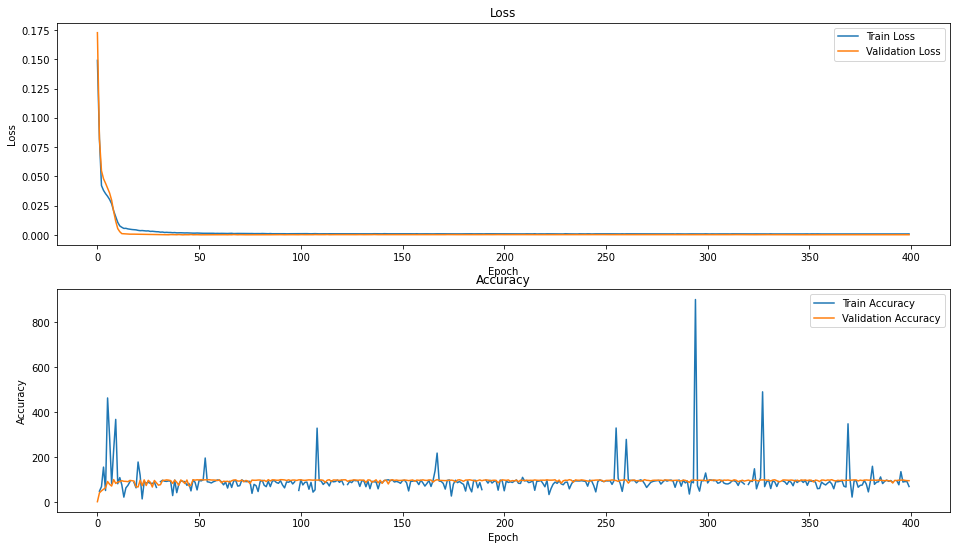

In [52]:
'''
train, validation loss 시각화
'''
plt.figure(figsize = (16, 9))
plt.subplot(211)
plt.plot(trn_loss_list, label = 'Train Loss')
plt.plot(val_loss_list, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')

plt.subplot(212)
plt.plot(trn_acc_list, label = 'Train Accuracy')
plt.plot(val_acc_list, label = 'Validation Accuracy')
plt.legend(loc = 'upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

In [53]:
'''
평가
'''
result = []
original = []
for i, batch in enumerate(test_dataloader):
    x, y = batch
    x = x.view(-1, sequence_length, input_size).to(device)
    y = y.to(device)
    pred = model(x)
    label = y
    loss = criterion(pred, label)
    result.append(pred.tolist())
    original.append(y.tolist())

In [54]:
print(len(result))
print(len(original))

45
45


In [55]:
test_result_data_np = np.array(sum(sum(result, []), []))
test_result_label_np = np.array(sum(sum(original, []), []))

'''
데이터프레임 reshape, columns 설정
'''
test_result_data_df = pd.DataFrame(test_result_data_np.reshape(-1, 1))
test_result_data_df.columns = ['Predicted Trend']

test_result_label_df = pd.DataFrame(test_result_label_np.reshape(-1, 1))
test_result_label_df.columns = ['Original Trend']

In [56]:
print(test_result_data_df.shape)
print(test_result_label_df.shape)

(486, 1)
(486, 1)


In [57]:
'''
결과 데이터 데이터프레임 결합
'''
reshaped_test_result_data_df = pd.concat([x_test_data_df['Month'], x_test_data_df['Trend'], test_result_data_df['Predicted Trend'], x_test_outlier_df], axis = 1)

In [58]:
'''
예측 데이터 데이터프레임 변환
'''
inversed_test_result_data_np = scaler.inverse_transform(reshaped_test_result_data_df)
inversed_test_result_data_df = pd.DataFrame(inversed_test_result_data_np)

In [59]:
'''
데이터프레임 컬럼 네임 변경
'''
inversed_test_result_data_df.columns = [
    'Month', 
    'Original Trend', 
    'Predicted Trend', 
    'Seasonal',
    'Resid'
]

In [60]:
'''
결과 데이터 데이터프레임 연산
'''
_predicted_data_df = inversed_test_result_data_df.drop(['Month', 'Original Trend'], axis = 1)
_original_data_df = inversed_test_result_data_df.drop(['Month', 'Predicted Trend'], axis = 1)

sum_predicted_data_df = pd.DataFrame({'Predicted Data': _predicted_data_df.sum(axis = 1)})
sum_original_data_df = pd.DataFrame({'Original Data': _original_data_df.sum(axis = 1)})

In [61]:
'''
결과 데이터 데이터프레임 생성
'''
result_predicted_data_df = pd.concat([inversed_test_result_data_df['Month'], sum_predicted_data_df['Predicted Data']], axis = 1)
result_original_data_df = pd.concat([inversed_test_result_data_df['Month'], sum_original_data_df['Original Data']], axis = 1)

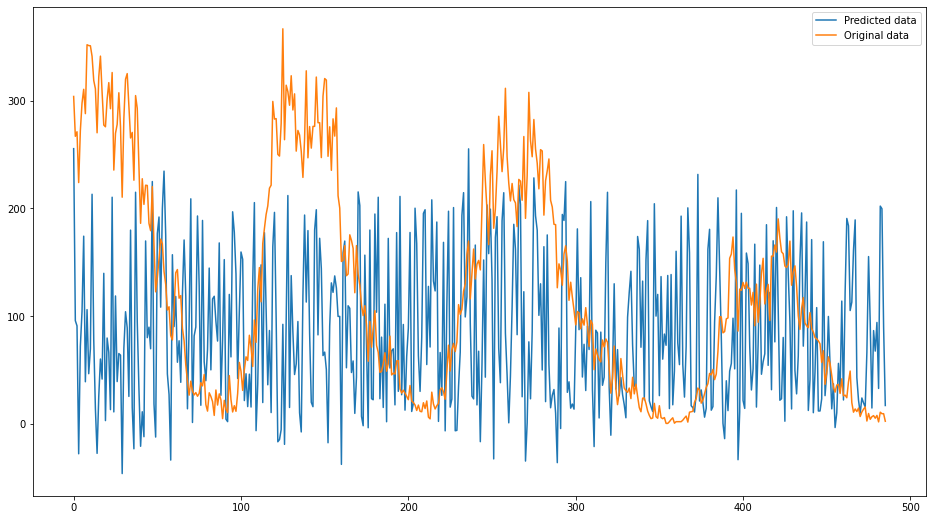

In [62]:
'''
결과 데이터 시각화
'''
plt.figure(figsize = (16, 9))
#plt.plot(inversed_test_result_data_df['Month'], result_predicted_data_df['Predicted Data'], label = 'Predicted data')
plt.plot(result_predicted_data_df['Predicted Data'], label = 'Predicted data')
#plt.plot(inversed_test_result_data_df['Month'], result_original_data_df['Original Data'], label = 'Target data')
plt.plot(result_original_data_df['Original Data'], label = 'Original data')
#plt.plot(inversed_test_result_data_df['Month'], result_df['Observed'][-int(len(scaled_result_df) * 0.15):].reset_index(drop = True), label = 'Original') # 실제로 원래 나와야하는 값
plt.legend(loc = 'upper right')
plt.show()